# DARPTests

In [1]:
import numpy as np
from time import time
from warnings import warn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
# Local Imports
from cpp_algorithms import imshow, imshow_scatter
from cpp_algorithms import get_all_area_maps, get_random_coords
from cpp_algorithms.darp.iterate import iterate
from cpp_algorithms.darp.continuity import get_area_indices, get_flood_matrix, min_point_map
from cpp_algorithms.darp.darp_helpers import rmse, get_c
from cpp_algorithms.darp.darp_helpers import get_no_obs_count, get_coverage_ratio, get_assigned_count
from cpp_algorithms.darp.darp_helpers import get_evaluation_matrices, get_assignment_matrix

In [3]:
"""
Initialization
"""
PATH = "../test_maps"
OBS = -1 # constant for obstacle area
COV =  0 # constant for coverage area

def get_test_init(number_of_drones, idx=0):
    area_map = get_all_area_maps(PATH)[idx]
    n = get_random_coords(area_map, number_of_drones)
    return area_map, n

In [4]:
"""
DARP Test Function
"""
def darp_run(map_no=3, n=3,epochs=300, start_points=None ,drone_speed=None, drone_coverage=None, use_flood=False):
    print(f"{map_no} :: " + "-"*34)
    area_map, start_points_ = get_test_init(n,map_no) # get test values
    if start_points == None:
        start_points = start_points_
    c = get_c(area_map)

    E = get_evaluation_matrices(start_points, area_map.copy()) # Distance maps for each
    A = get_assignment_matrix(E) # Assignment matrix.
    
    m = n if n < 6 else 5
    [imshow(e, 1,m,i+1, figsize=(22,5))for i,e in enumerate(E[:m-2])]
    imshow(A, 1,m,m-1)
    imshow_scatter([start_points], color="white")
    
    print(start_points)

    if drone_coverage is None or drone_speed is None:
        drone_speed = np.ones(n)        
        drone_coverage = np.ones(n)     

    nobs_count = get_no_obs_count(area_map)                # Number of coverable cells.
    coverage_ratio = get_coverage_ratio(drone_speed, drone_coverage) 
    assigned_count = get_assigned_count(A)                 # Counts in the form of an array
    optimal_count = np.round(coverage_ratio * nobs_count)  # Optimal number of cells assigned to each drone
    print("target count  : ",optimal_count)
    print("before darp")
    print("current count : ",assigned_count)
    print("RMSE : ",rmse(assigned_count, optimal_count))
    print()
    
    flood_matrix=None
    if use_flood:
        print("\ncomputing flood matrix...")
        flood_matrix = get_flood_matrix(area_map, pbar=True)

    tic = time()
    print(f"running DARP for {epochs} epochs...")
    A, losses = iterate(epochs, start_points, E.copy(), c, nobs_count, coverage_ratio, \
                        flood_matrix=flood_matrix, print_stuff=False)
    print(f'time taken for {epochs} epochs : {(time()-tic)*1000:.2f} ms\n')
    
    assigned_count= get_assigned_count(A)
    print("after darp")
    print("current_count : ", assigned_count)
    print("RMSE : ",rmse(assigned_count, optimal_count))
    print("\n")

    imshow(A,1,m,m);
    if use_flood:
        for i in range(1,m):
            imshow(min_point_map(A, i, flood_matrix),1,m,i,figsize=(22,5))
        imshow(A,1,m,m);
    plt.figure(figsize=(22,5))
    plt.plot(losses)
    plt.show()
    
    return A,losses

4 :: ----------------------------------
/home/kaka/.local/lib/python3.6/site-packages/cpp_algorithms/common_helpers.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return list(np.array(ams)[am_idx])
[(18, 17), (18, 28), (12, 16), (28, 23)]
target count  :  [164. 164. 164. 164.]
before darp
current count :  [ 25 134 238 257]
RMSE :  92.66336924588917


computing flood matrix...


  0%|          | 0/654 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 803.67 ms

after darp
current_count :  [165 167 167 155]
RMSE :  5.0




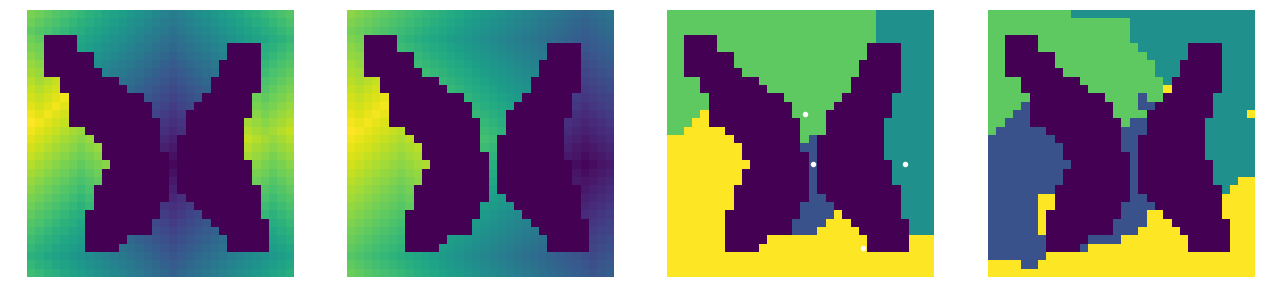

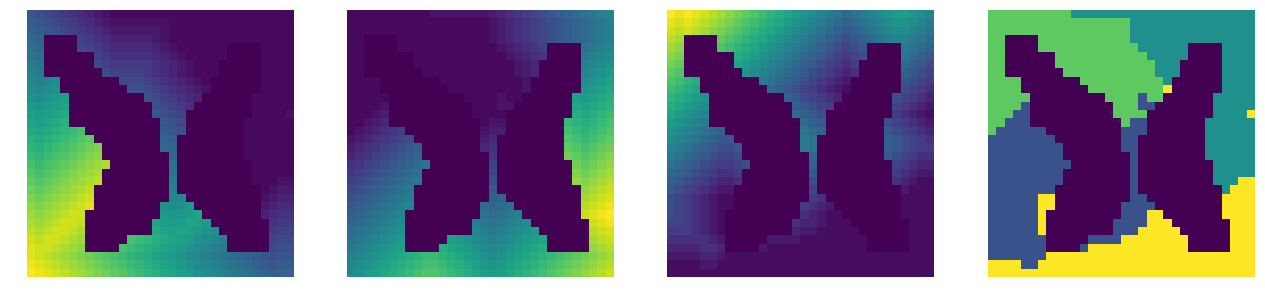

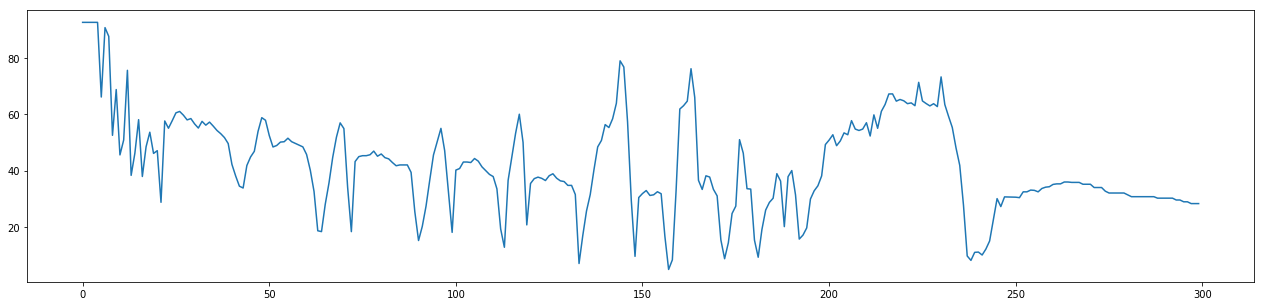

In [5]:
_ = darp_run(4, 4,epochs=300, start_points=None, use_flood=True)

# Tests
All have been run for 300 epochs.

## Larger Maps > (50,50)
With flood matrix

13 :: ----------------------------------
[(22, 101), (49, 2), (42, 25), (22, 16), (47, 9)]
target count  :  [736. 736. 736. 736. 736.]
before darp
current count :  [2073   13  826  682   86]
RMSE :  740.7852590326025


computing flood matrix...


  0%|          | 0/3680 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 57553.09 ms

after darp
current_count :  [743 725 792 624 796]
RMSE :  62.369864518050704




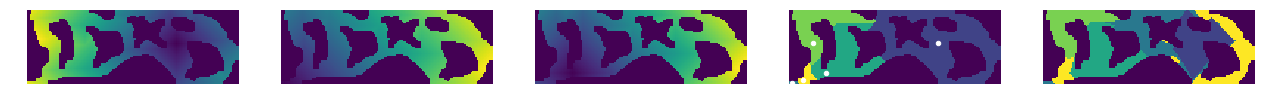

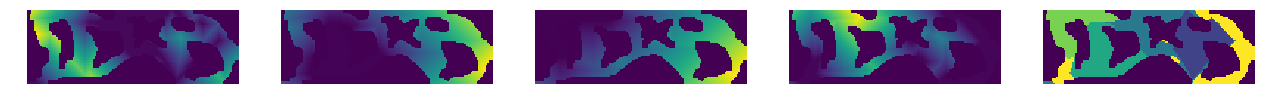

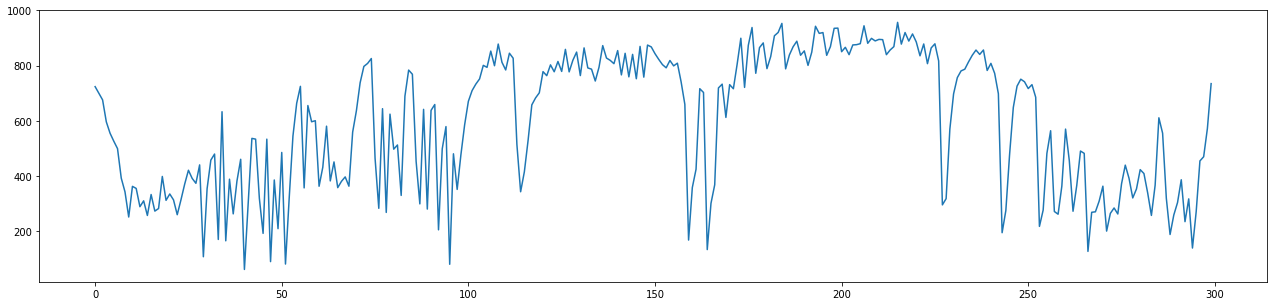

In [6]:
# start_points = [(25, 9), (22, 9), (38, 36), (21, 25), (22, 8)]
start_points=None
A, losses = darp_run(13, 5,epochs=300, start_points=start_points, use_flood=True)

15 :: ----------------------------------
[(37, 134), (8, 137), (20, 24), (12, 93), (24, 28)]
target count  :  [877. 877. 877. 877. 877.]
before darp
current count :  [ 505  633 1698 1295  252]
RMSE :  536.1548283844882


computing flood matrix...


  0%|          | 0/4383 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 6729.29 ms

after darp
current_count :  [1155  825 1087 1070  246]
RMSE :  334.51397579174477




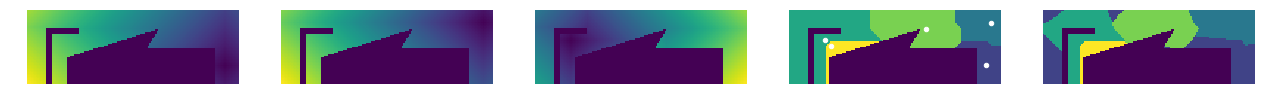

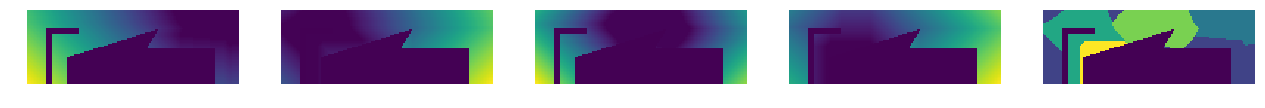

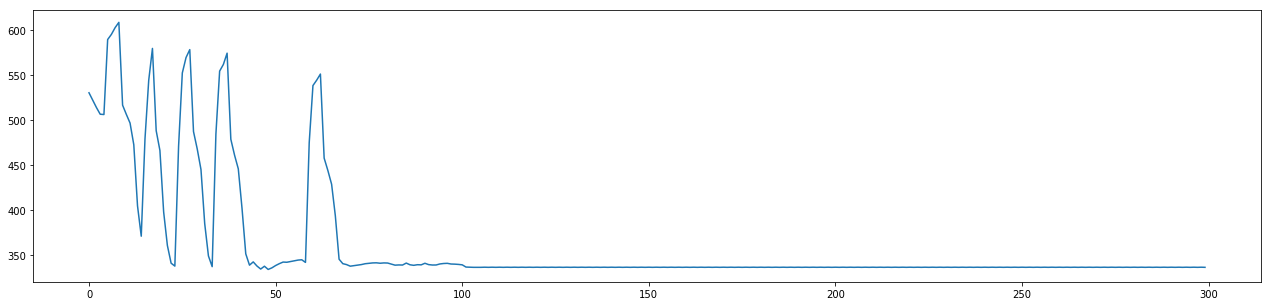

In [7]:
start_points=None
A, losses = darp_run(15, 5,epochs=300, start_points=start_points, use_flood=True)

## Large maps
Without flood matrix

17 :: ----------------------------------
[(46, 159), (79, 75), (43, 154), (46, 243), (141, 33)]
target count  :  [5173. 5173. 5173. 5173. 5173.]
before darp
current count :  [6542 7494 3295 5985 2550]
RMSE :  1914.5526370408309


computing flood matrix...


  0%|          | 0/25866 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 257374.49 ms

after darp
current_count :  [5187 5143 5184 5191 5161]
RMSE :  18.35755975068582




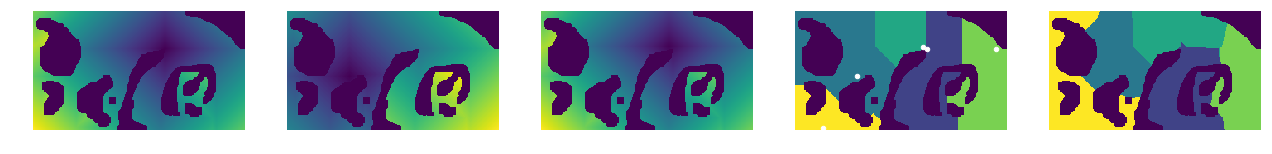

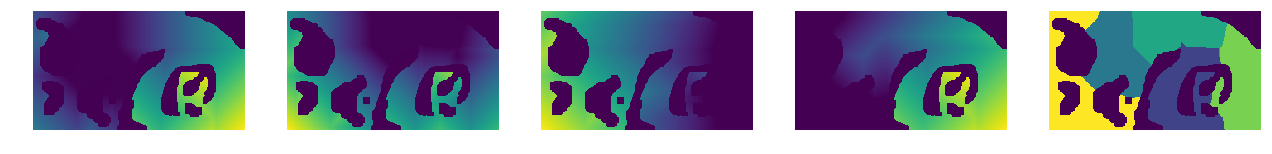

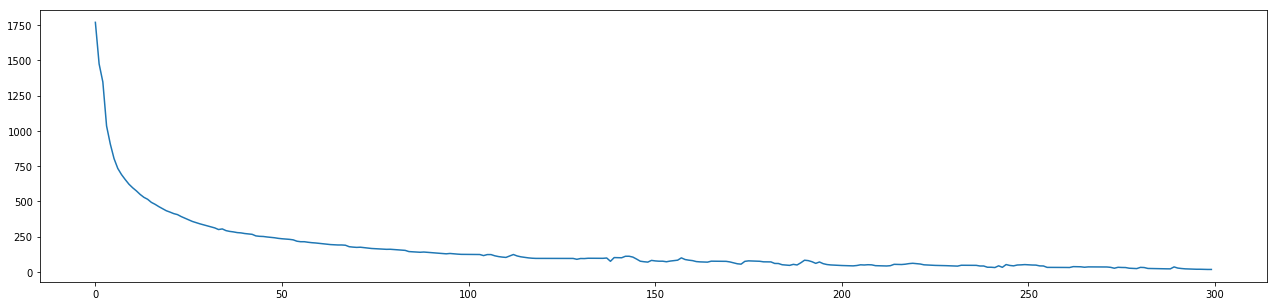

In [8]:
start_points=None
A, losses = darp_run(17, 5,epochs=300, start_points=start_points, use_flood=True)

## With the flood matrix
(Small maps)

0 :: ----------------------------------
[(0, 12), (21, 28), (6, 18), (7, 29)]
target count  :  [198. 198. 198. 198.]
before darp
current count :  [ 80 548  68  98]
RMSE :  202.06682063119615


computing flood matrix...


  0%|          | 0/794 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 1061.80 ms

after darp
current_count :  [166 209 212 207]
RMSE :  18.854707634964804




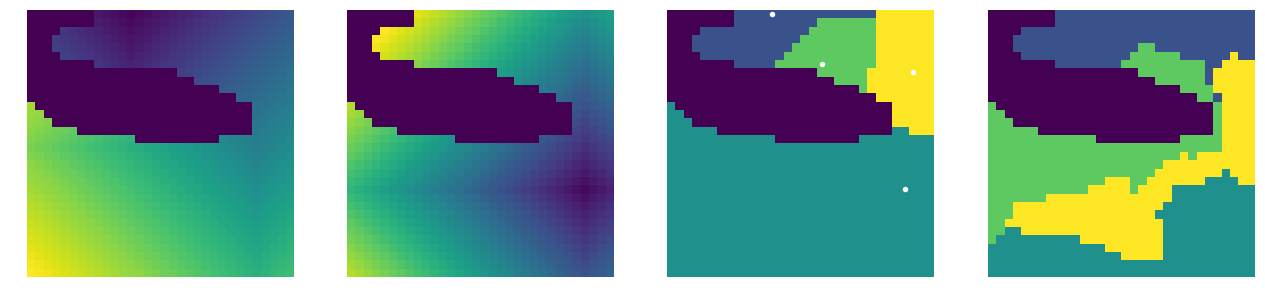

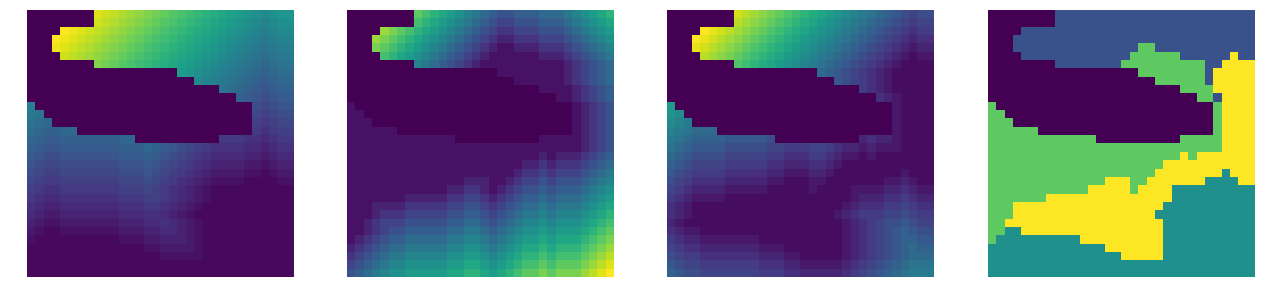

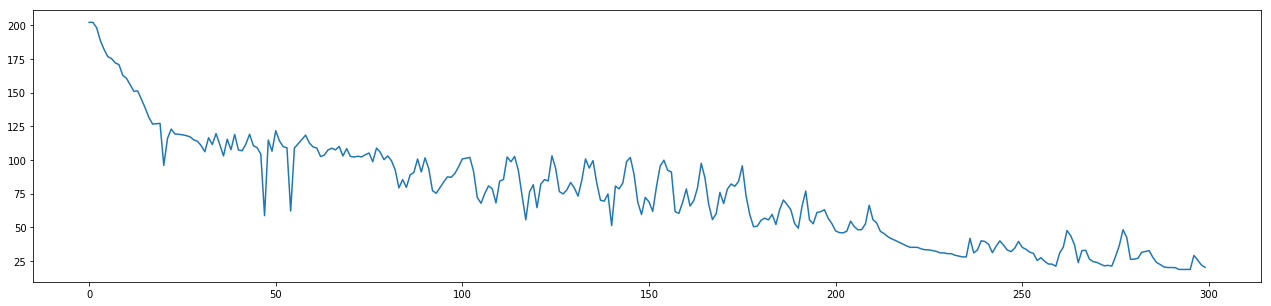

1 :: ----------------------------------
[(10, 18), (21, 3), (16, 17), (5, 2)]
target count  :  [160. 160. 160. 160.]
before darp
current count :  [169 106 247 117]
RMSE :  55.71130944431301


computing flood matrix...


  0%|          | 0/639 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 477.88 ms

after darp
current_count :  [171 133 169 166]
RMSE :  15.548311805466213




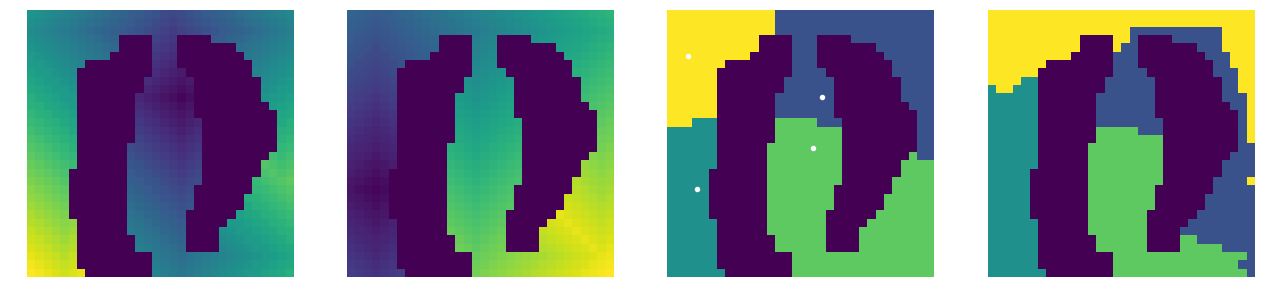

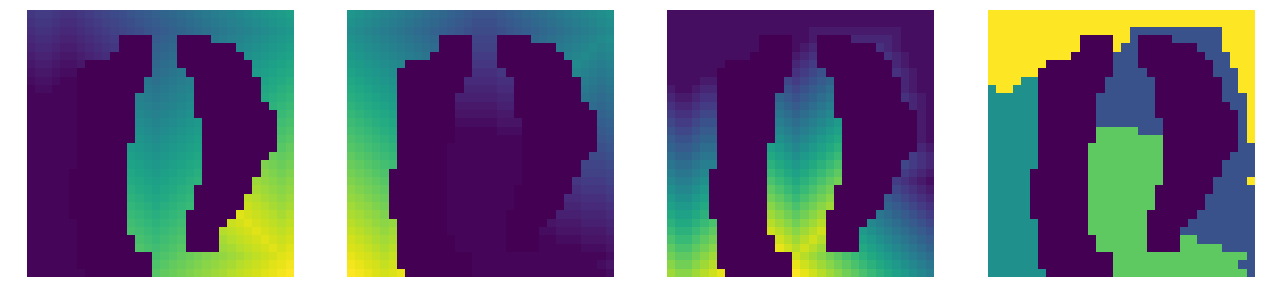

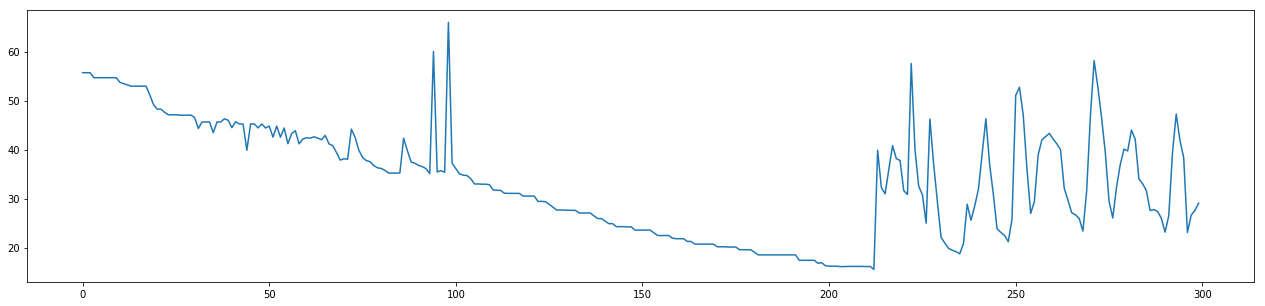

2 :: ----------------------------------
[(11, 28), (28, 12), (3, 11), (26, 13)]
target count  :  [181. 181. 181. 181.]
before darp
current count :  [179 141 230 173]
RMSE :  31.894356867634123


computing flood matrix...


  0%|          | 0/723 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 293.86 ms

after darp
current_count :  [180 180 182 181]
RMSE :  0.8660254037844386




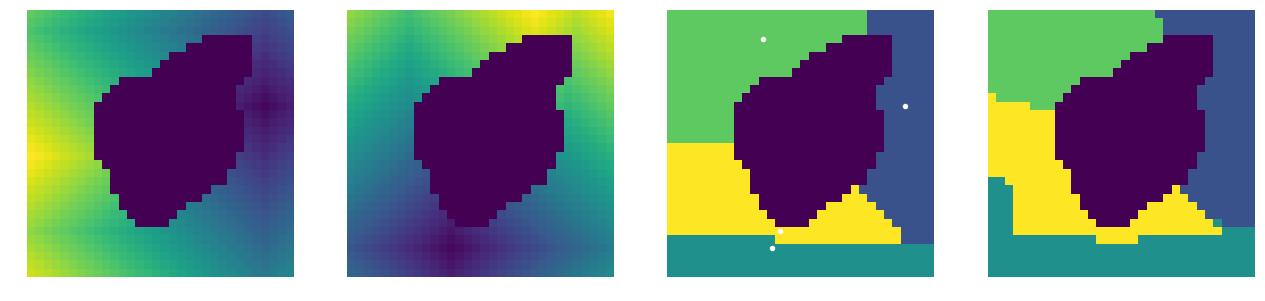

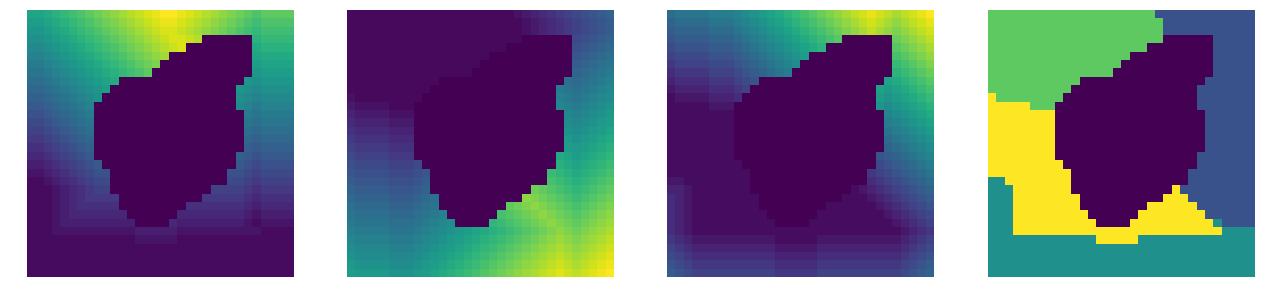

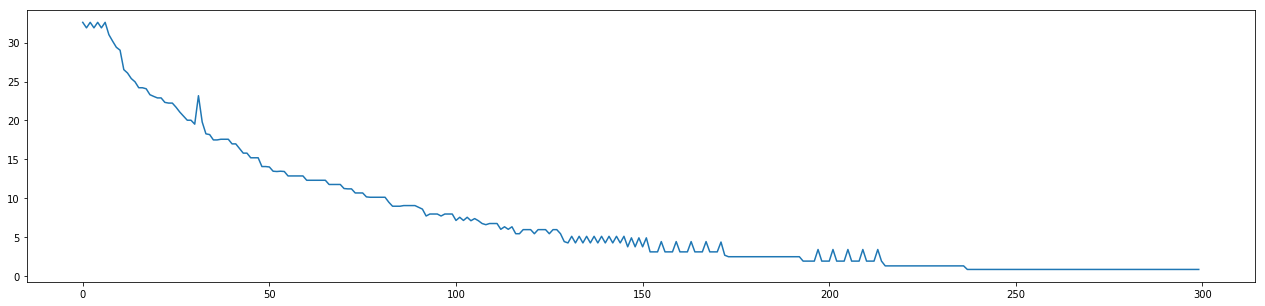

3 :: ----------------------------------
[(0, 14), (1, 29), (17, 2), (12, 3)]
target count  :  [172. 172. 172. 172.]
before darp
current count :  [145 207 256  81]
RMSE :  65.74762353119692


computing flood matrix...


  0%|          | 0/689 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 650.30 ms

after darp
current_count :  [169 164 178 178]
RMSE :  6.020797289396148




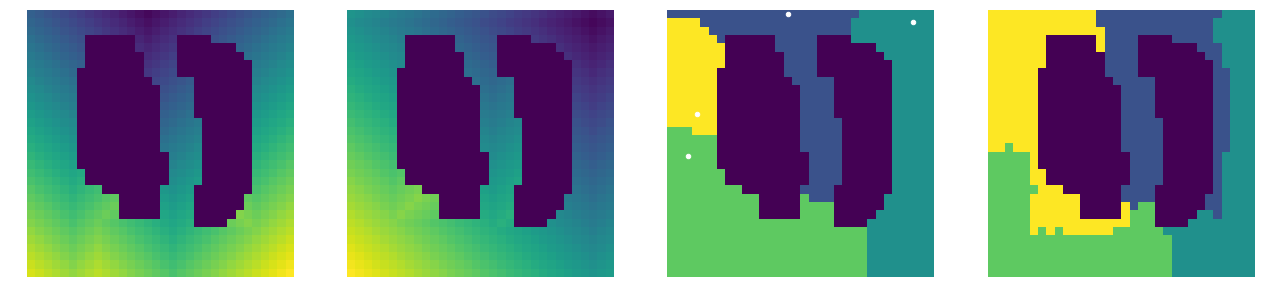

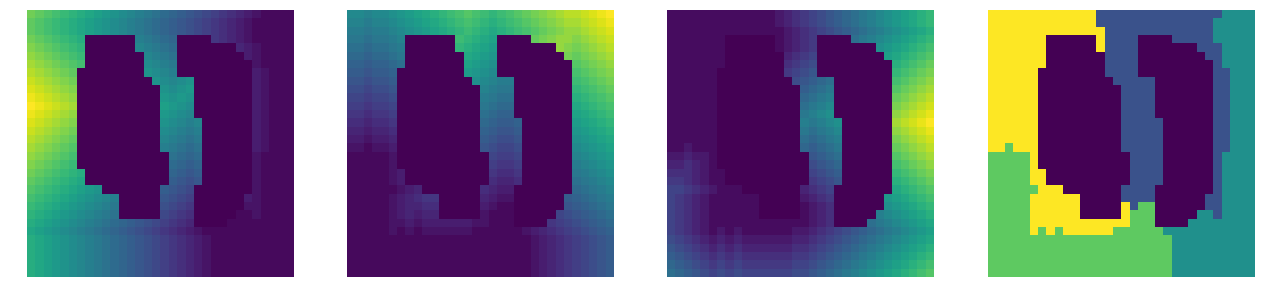

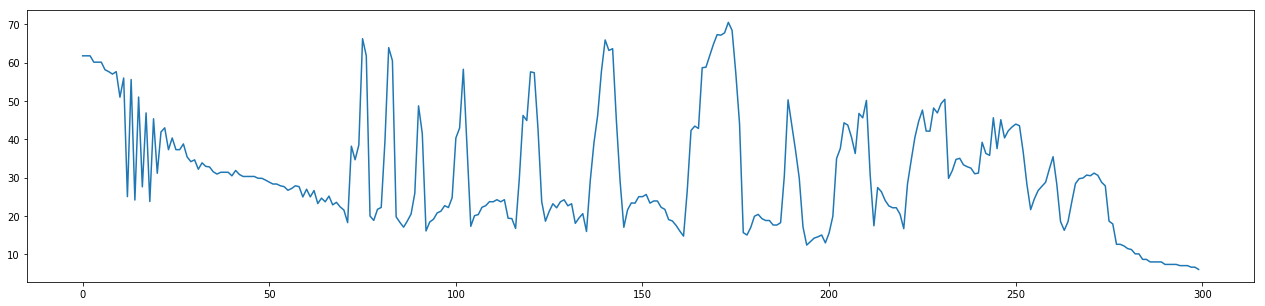

4 :: ----------------------------------
[(0, 10), (0, 24), (26, 6), (31, 12)]
target count  :  [164. 164. 164. 164.]
before darp
current count :  [158 183 159 154]
RMSE :  11.423659658795863


computing flood matrix...


  0%|          | 0/654 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 338.74 ms

after darp
current_count :  [164 164 163 163]
RMSE :  0.7071067811865476




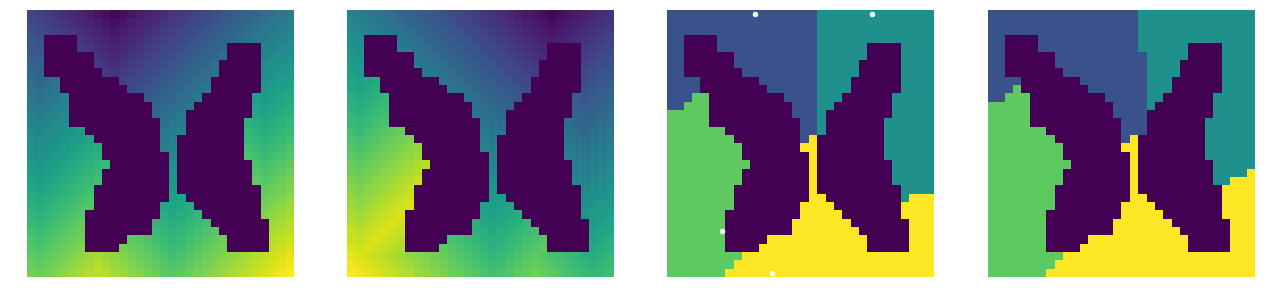

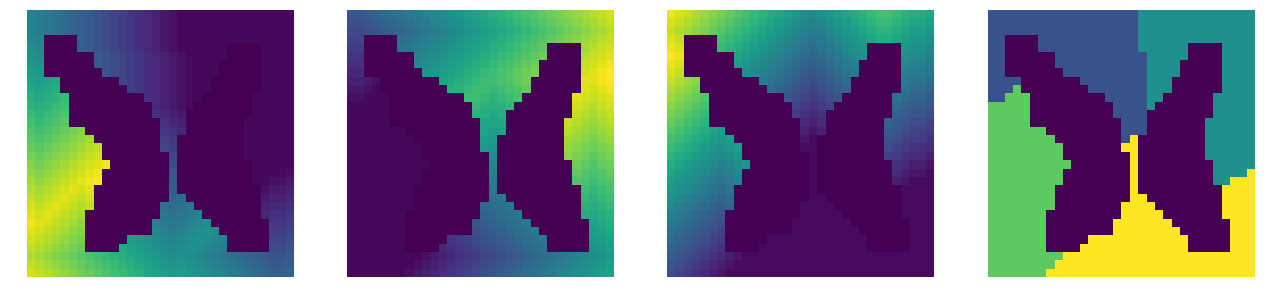

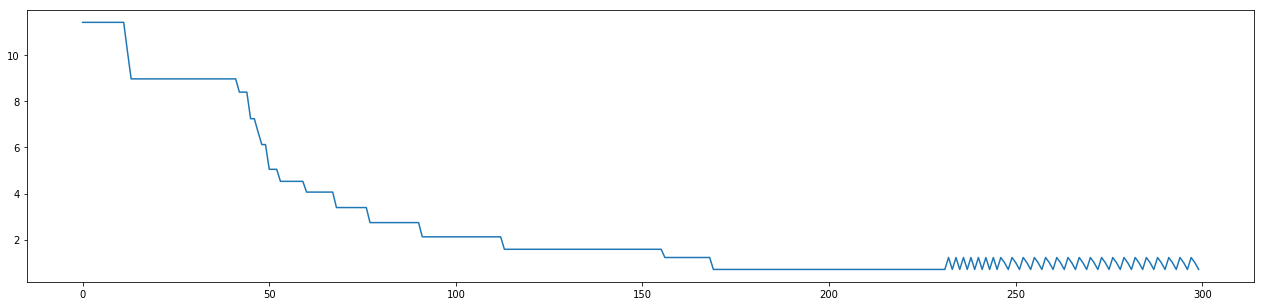

5 :: ----------------------------------
[(0, 13), (2, 27), (18, 5), (17, 13)]
target count  :  [181. 181. 181. 181.]
before darp
current count :  [119 102 118 386]
RMSE :  118.40502523119532


computing flood matrix...


  0%|          | 0/725 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 1098.07 ms

after darp
current_count :  [162 140 188 235]
RMSE :  35.380079140668975




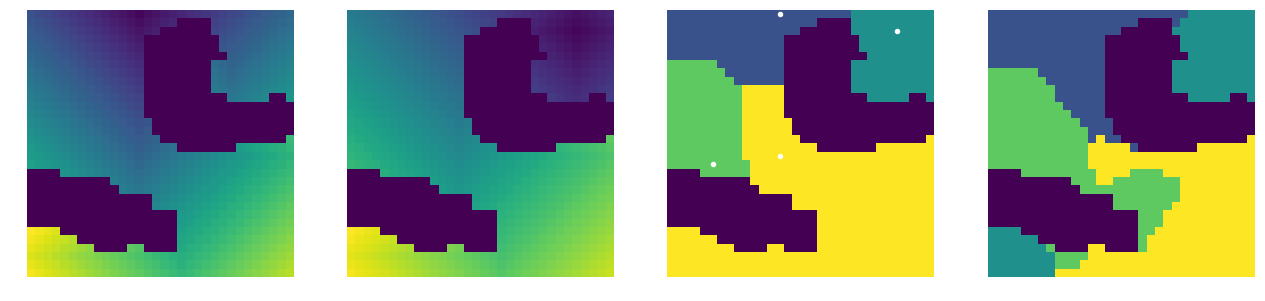

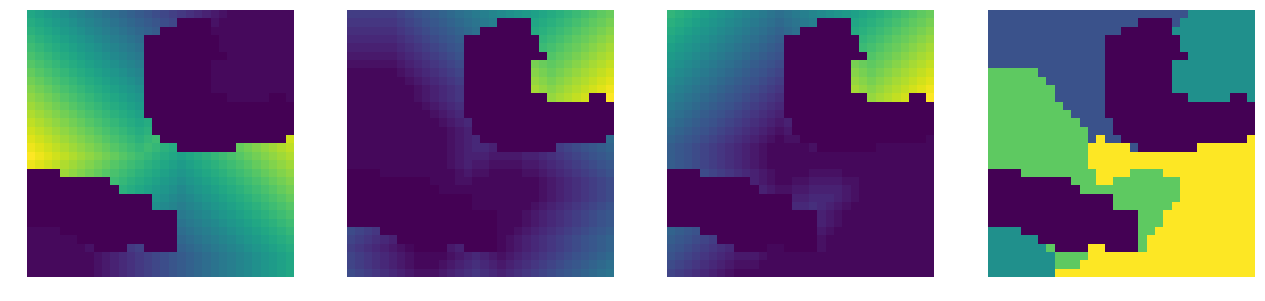

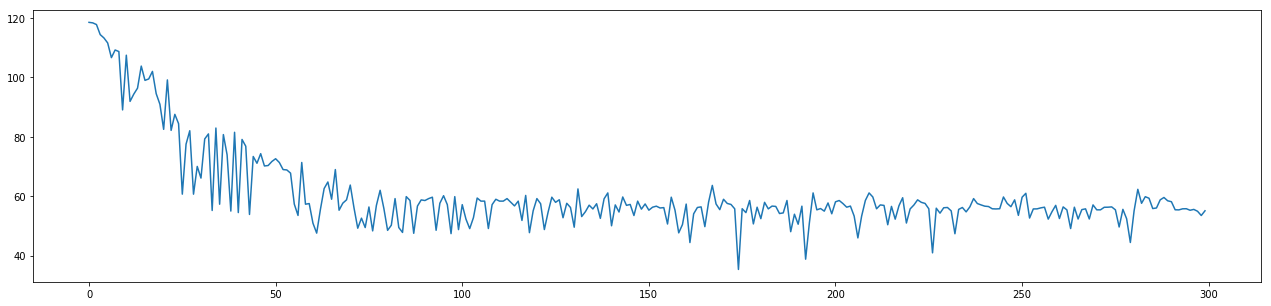

6 :: ----------------------------------
[(0, 22), (26, 10), (31, 0), (17, 28)]
target count  :  [152. 152. 152. 152.]
before darp
current count :  [270 132  65 143]
RMSE :  74.11814892453805


computing flood matrix...


  0%|          | 0/610 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 608.67 ms

after darp
current_count :  [159 145 131 175]
RMSE :  16.34013463836819




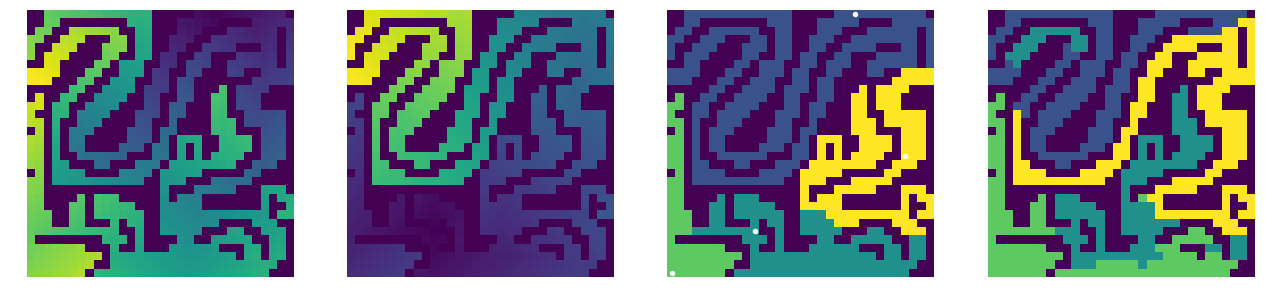

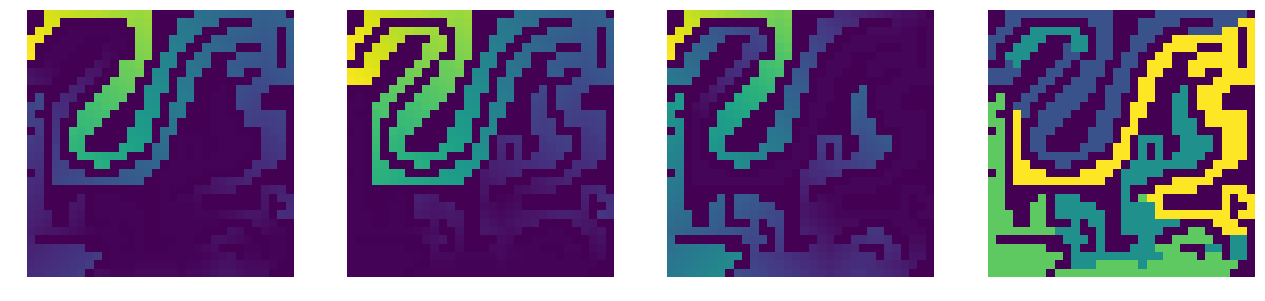

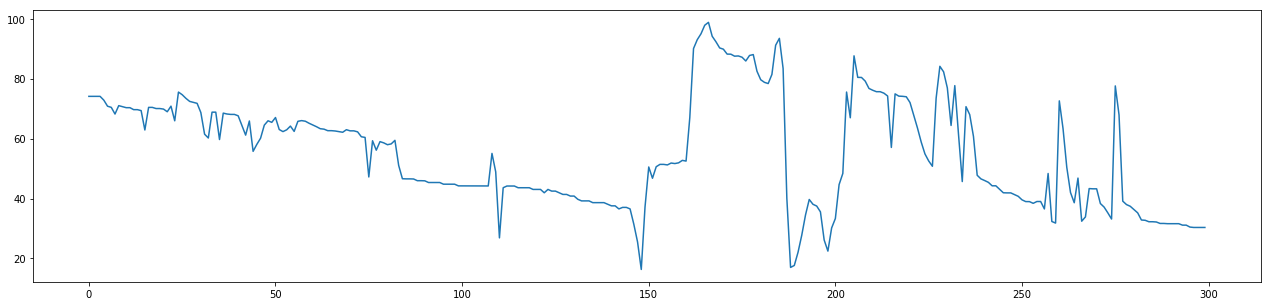

7 :: ----------------------------------
[(11, 25), (0, 29), (17, 26), (26, 13)]
target count  :  [193. 193. 193. 193.]
before darp
current count :  [ 59 352 122 239]
RMSE :  112.2430398733035


computing flood matrix...


  0%|          | 0/772 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 903.19 ms

after darp
current_count :  [200 217 170 185]
RMSE :  17.449928366615147




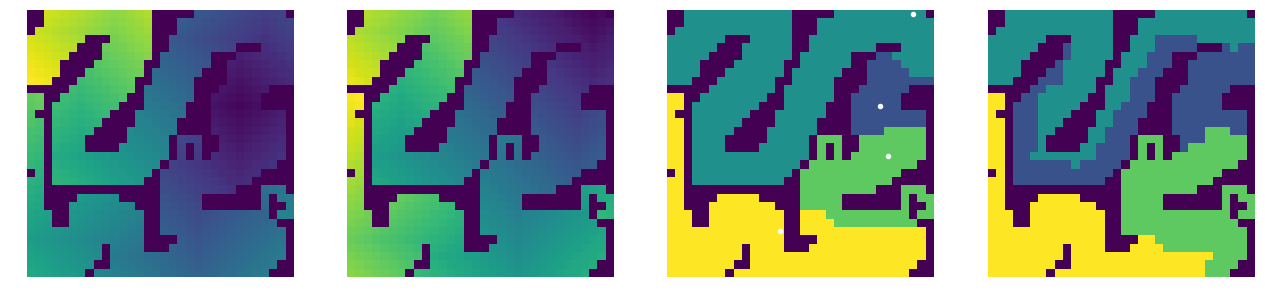

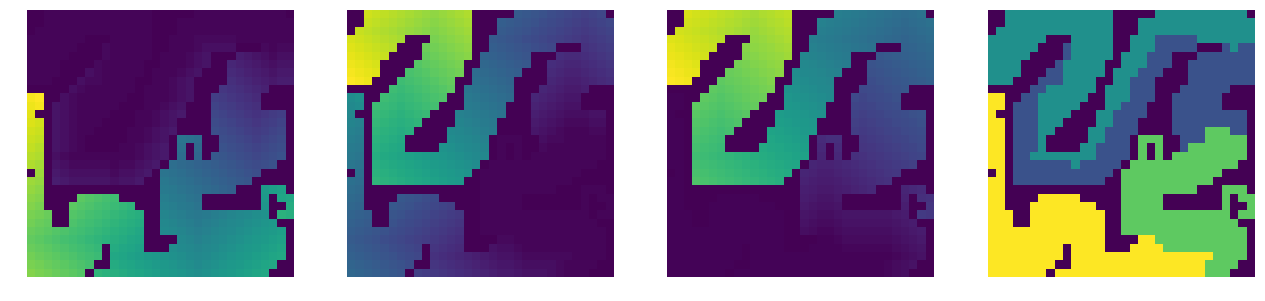

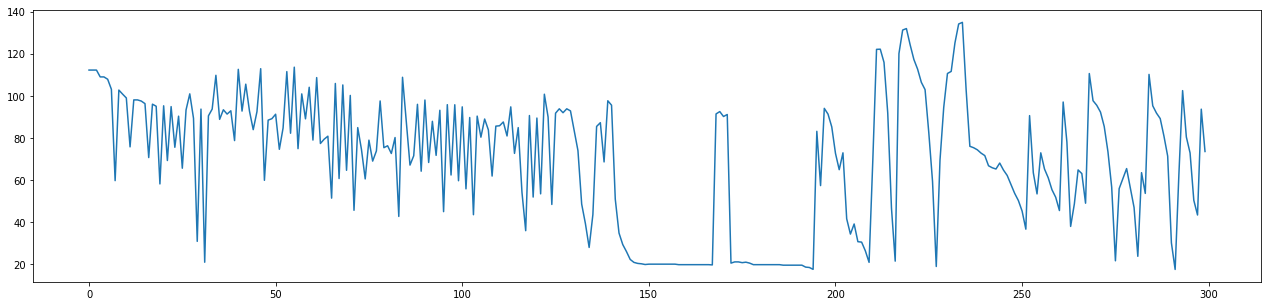

8 :: ----------------------------------
[(12, 22), (19, 31), (10, 26), (15, 8)]
target count  :  [179. 179. 179. 179.]
before darp
current count :  [247  70  36 363]
RMSE :  133.0507422001095


computing flood matrix...


  0%|          | 0/716 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 514.95 ms

after darp
current_count :  [179 179 179 179]
RMSE :  0.0




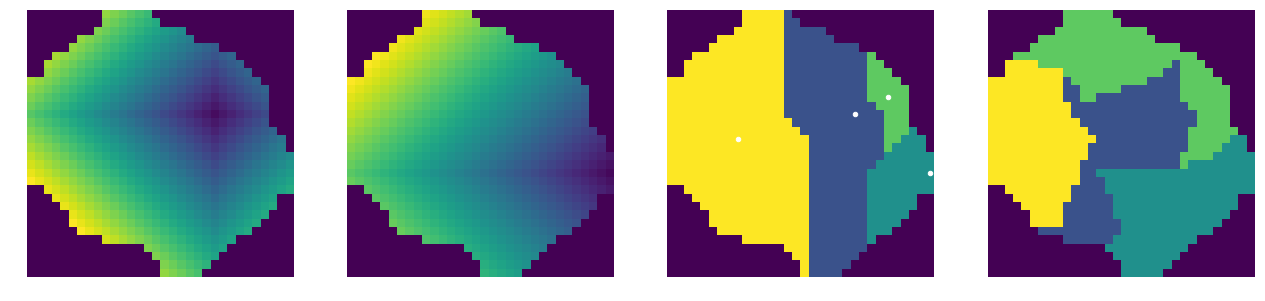

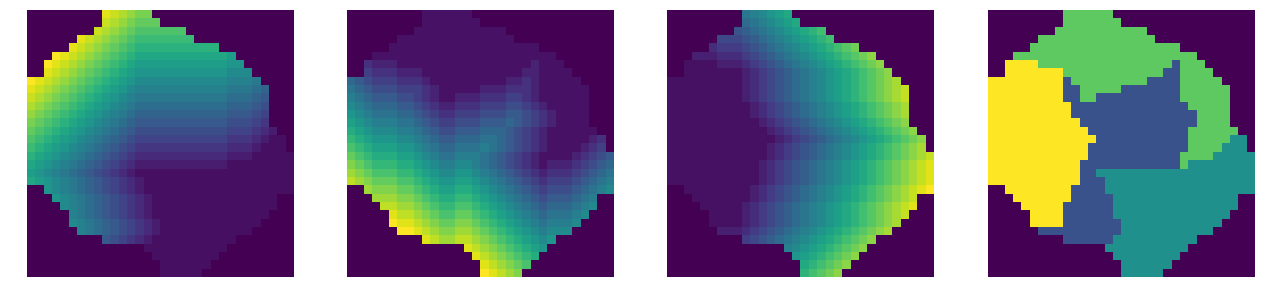

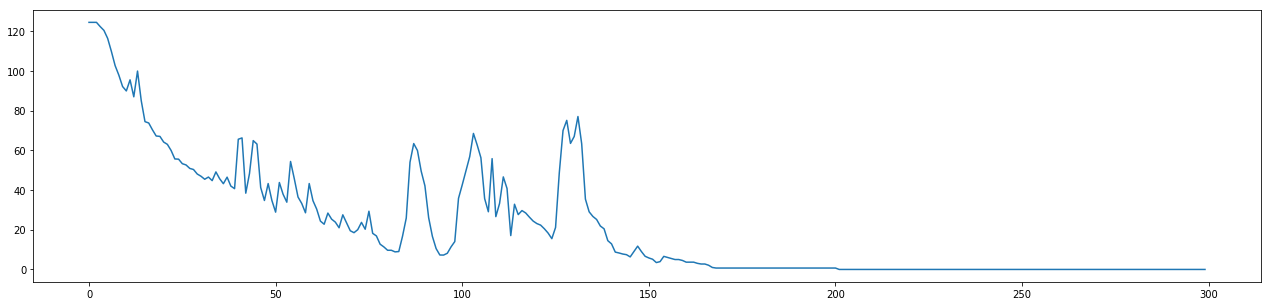

9 :: ----------------------------------
[(3, 48), (9, 29), (0, 41), (0, 18)]
target count  :  [368. 368. 368. 368.]
before darp
current count :  [1060  162   78  172]
RMSE :  401.19072770940255


computing flood matrix...


  0%|          | 0/1472 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 1523.53 ms

after darp
current_count :  [396 408 457 211]
RMSE :  93.4799443731114




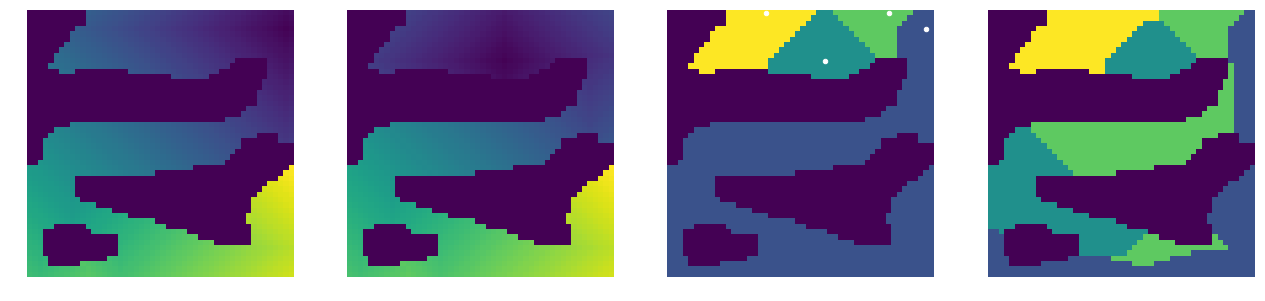

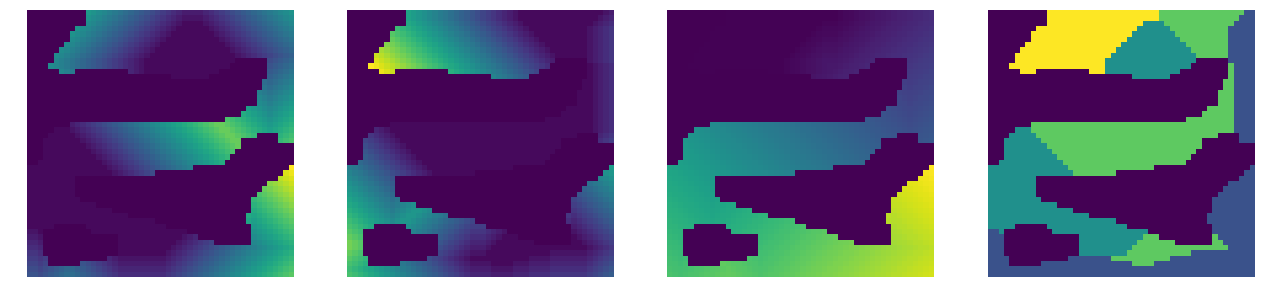

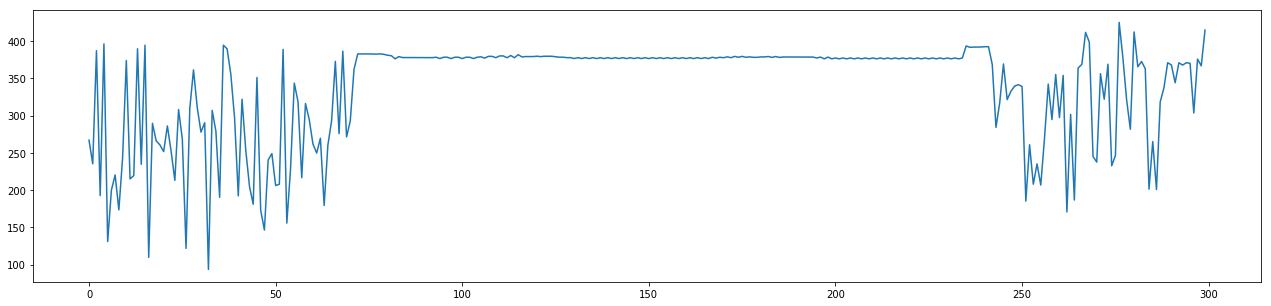

10 :: ----------------------------------
[(25, 2), (30, 19), (13, 17), (33, 27)]
target count  :  [330. 330. 330. 330.]
before darp
current count :  [183  97 649 389]
RMSE :  212.80272554645535


computing flood matrix...


  0%|          | 0/1318 [00:00<?, ?it/s]

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 2947.66 ms

after darp
current_count :  [313 312 396 297]
RMSE :  38.91657744458009




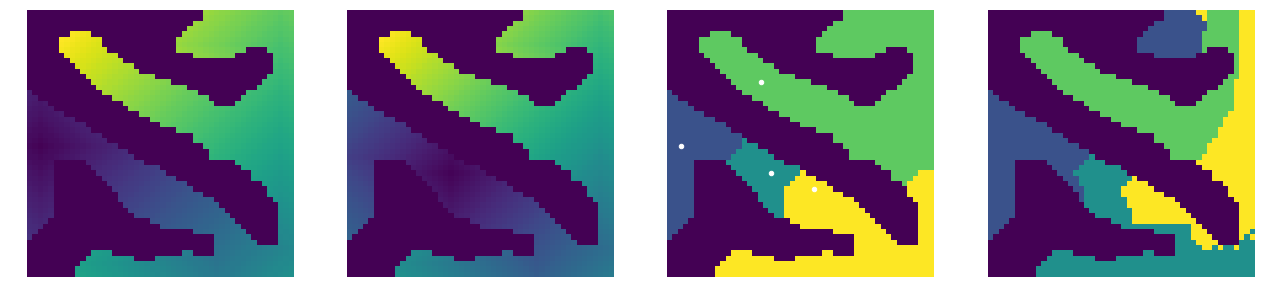

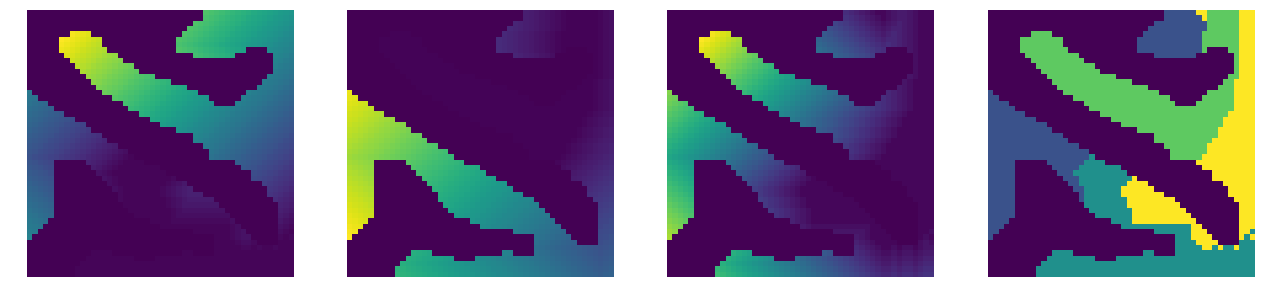

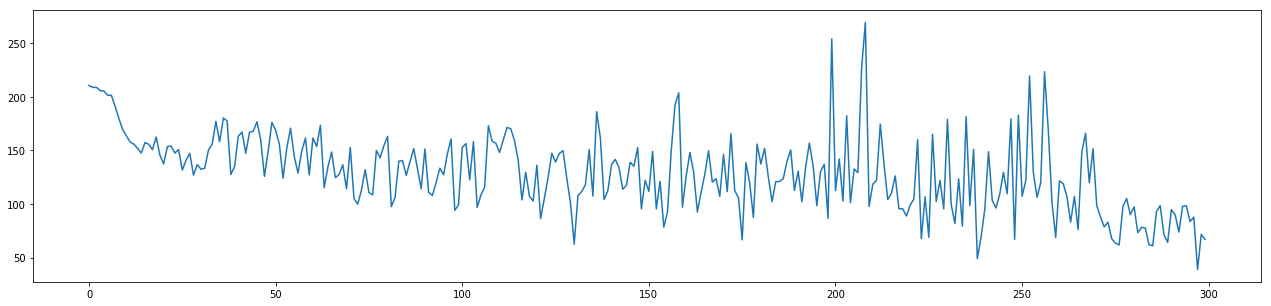

In [9]:
for i in range(11):
    A, losses = darp_run(i, 4, epochs=300, start_points=start_points, use_flood=True)

## Without the Flood Matrix

0 :: ----------------------------------
[(30, 28), (25, 10), (14, 30), (17, 16)]
target count  :  [198. 198. 198. 198.]
before darp
current count :  [119 237 298 140]
RMSE :  72.67392930067838

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 2108.68 ms

after darp
current_count :  [178 172 226 218]
RMSE :  23.769728648009426




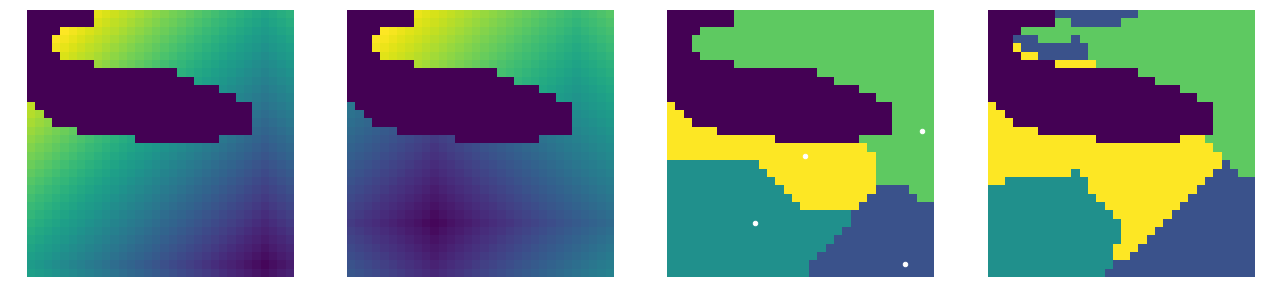

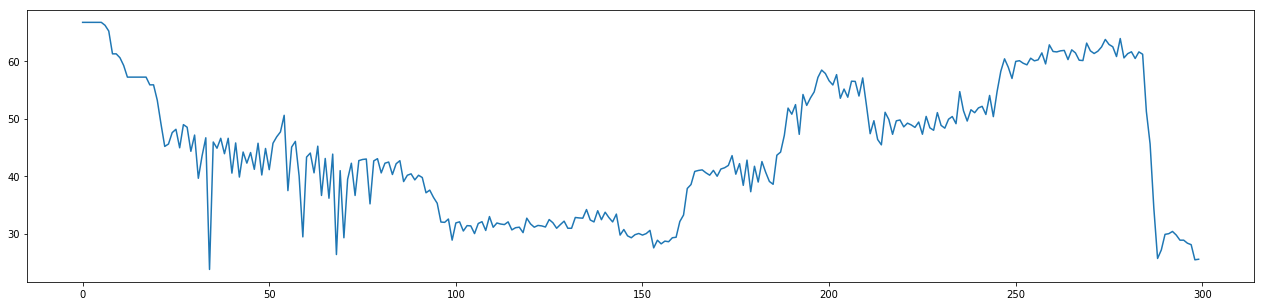

1 :: ----------------------------------
[(4, 3), (3, 8), (14, 15), (29, 25)]
target count  :  [160. 160. 160. 160.]
before darp
current count :  [190 128 151 170]
RMSE :  22.940139493908923

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 397.50 ms

after darp
current_count :  [168 163 160 148]
RMSE :  7.365459931328117




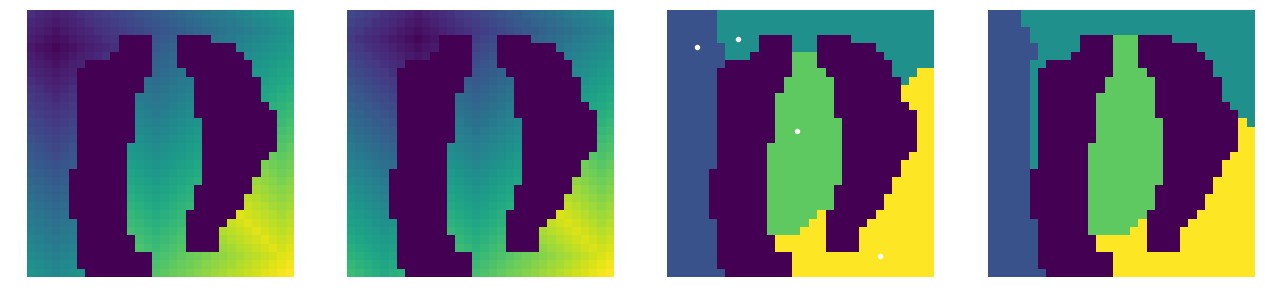

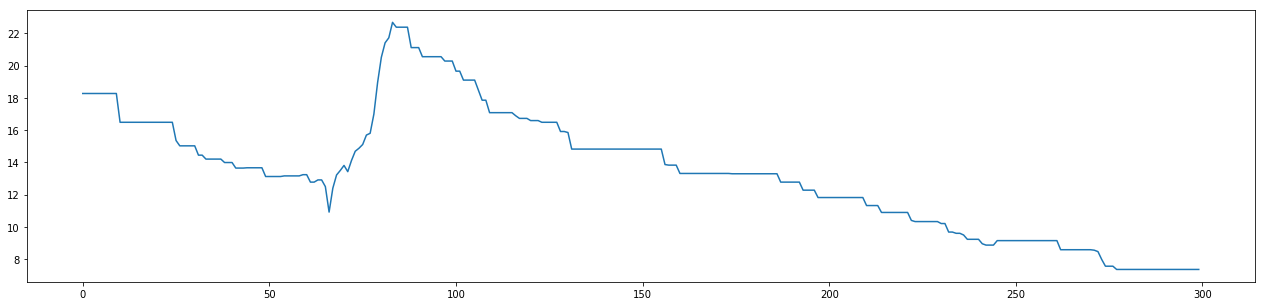

2 :: ----------------------------------
[(1, 29), (4, 1), (1, 19), (8, 1)]
target count  :  [181. 181. 181. 181.]
before darp
current count :  [276  75  72 300]
RMSE :  107.59065944588312

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 571.05 ms

after darp
current_count :  [181 180 181 181]
RMSE :  0.5




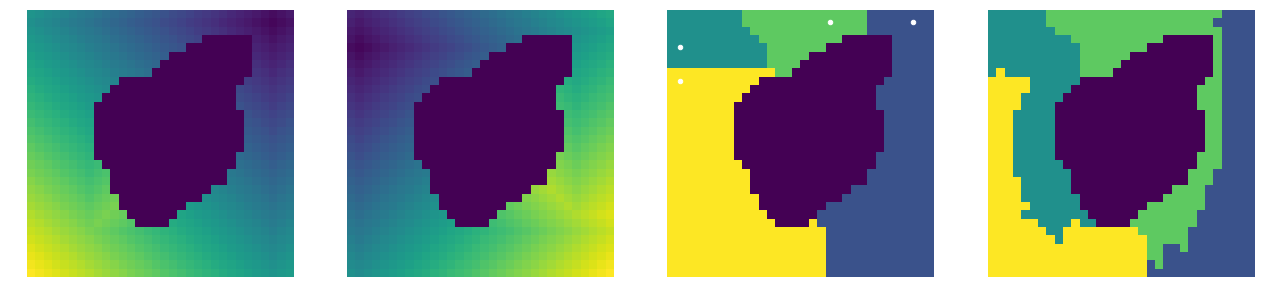

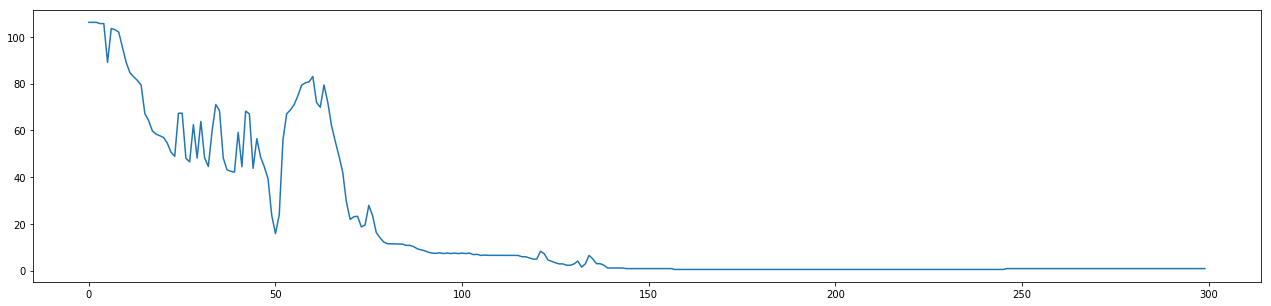

3 :: ----------------------------------
[(27, 26), (8, 18), (31, 15), (19, 17)]
target count  :  [172. 172. 172. 172.]
before darp
current count :  [170 239 233  47]
RMSE :  77.19941709624497

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 1007.12 ms

after darp
current_count :  [173 175 171 170]
RMSE :  1.9364916731037085




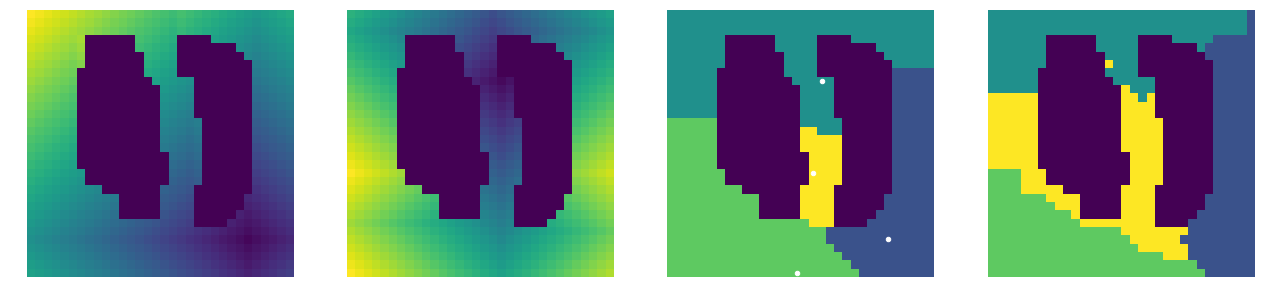

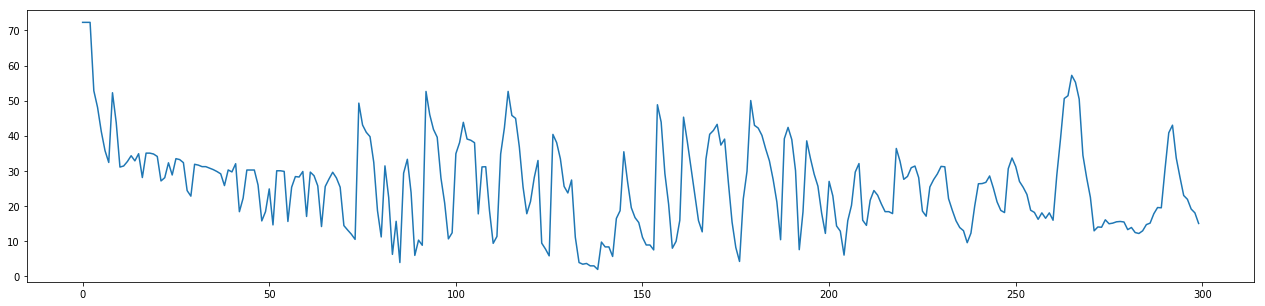

4 :: ----------------------------------
[(11, 18), (24, 0), (1, 8), (26, 21)]
target count  :  [164. 164. 164. 164.]
before darp
current count :  [192 171 103 188]
RMSE :  35.812009158939965

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 321.25 ms

after darp
current_count :  [163 164 163 164]
RMSE :  0.7071067811865476




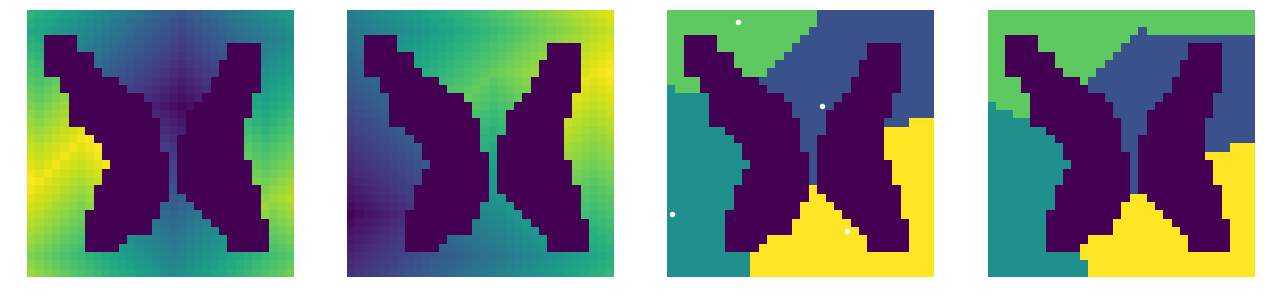

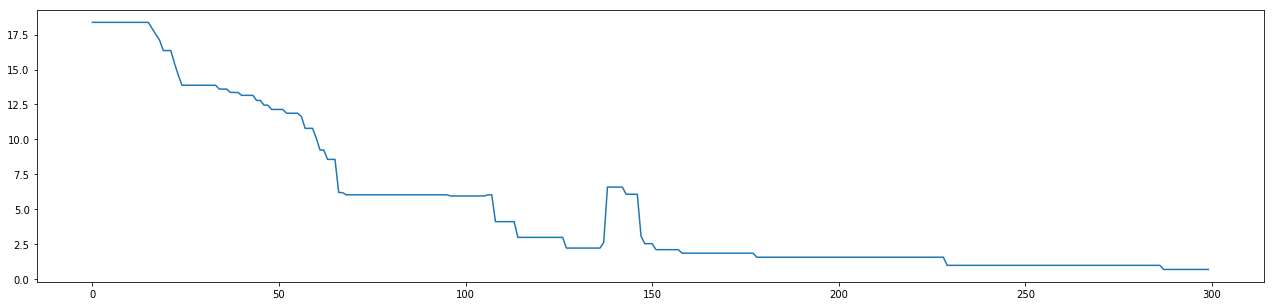

5 :: ----------------------------------
[(24, 18), (16, 31), (12, 9), (17, 16)]
target count  :  [181. 181. 181. 181.]
before darp
current count :  [203  78 382  62]
RMSE :  128.1161582315049

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 2277.02 ms

after darp
current_count :  [173 166 193 193]
RMSE :  12.010412149464313




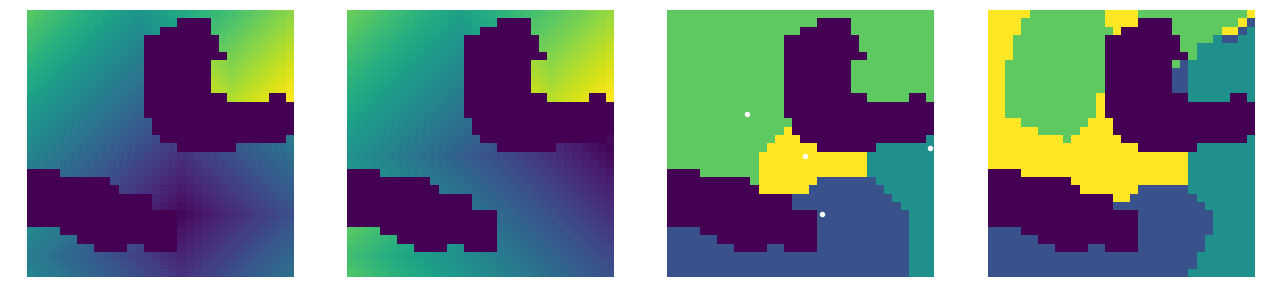

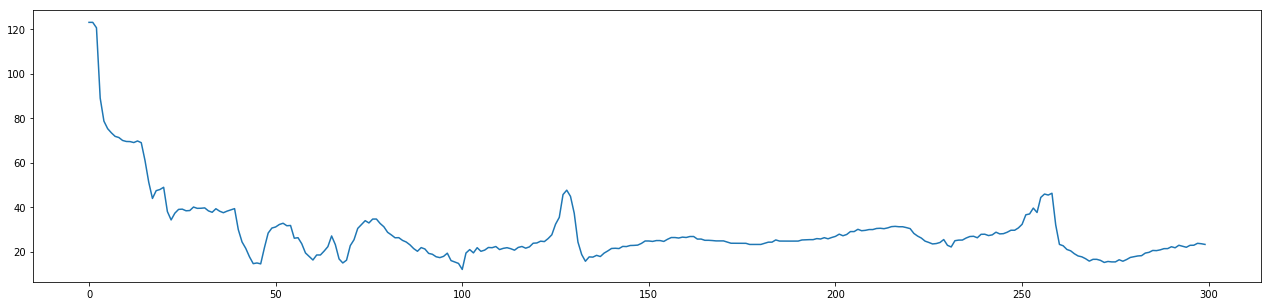

6 :: ----------------------------------
[(7, 15), (26, 6), (8, 15), (16, 3)]
target count  :  [152. 152. 152. 152.]
before darp
current count :  [117 302  98  93]
RMSE :  86.77845354694908

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 1823.24 ms

after darp
current_count :  [147 183 113 167]
RMSE :  26.13426869074396




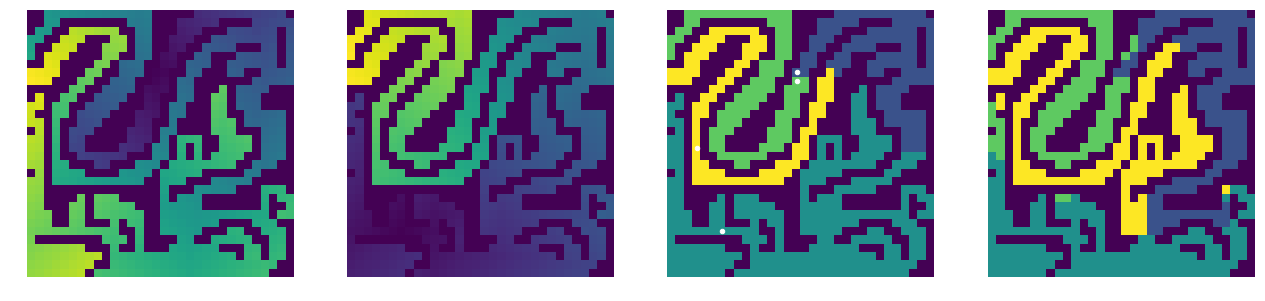

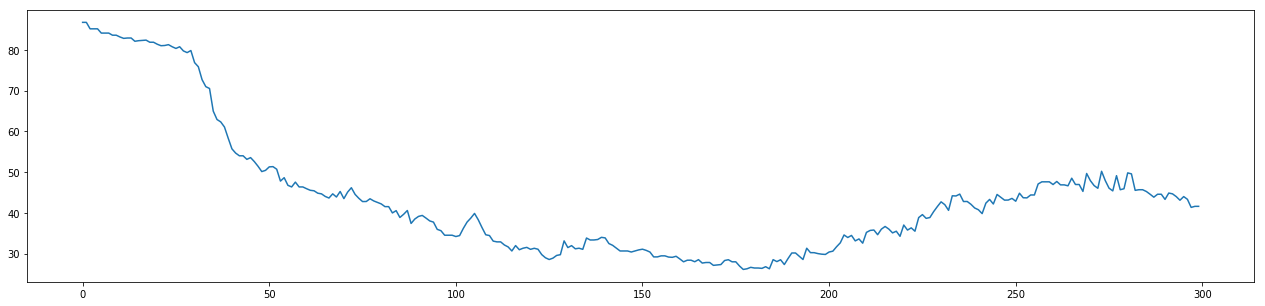

7 :: ----------------------------------
[(16, 29), (10, 1), (13, 16), (24, 20)]
target count  :  [193. 193. 193. 193.]
before darp
current count :  [145  66 309 252]
RMSE :  94.03456811194488

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 1576.34 ms

after darp
current_count :  [200 175 198 199]
RMSE :  10.41633332799983




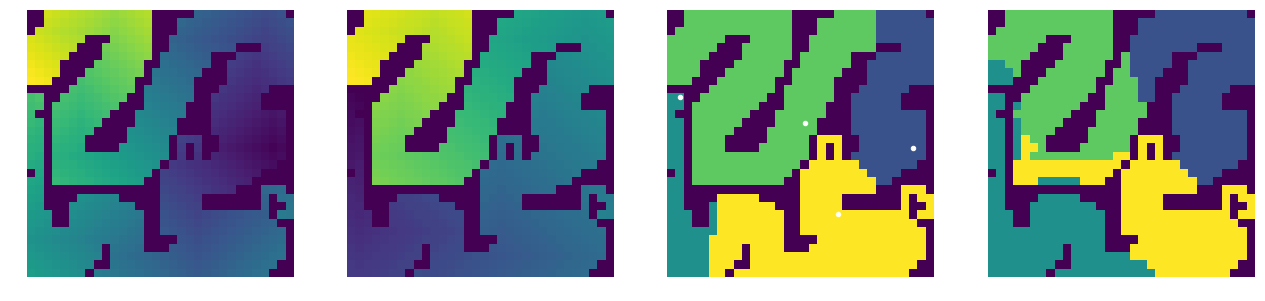

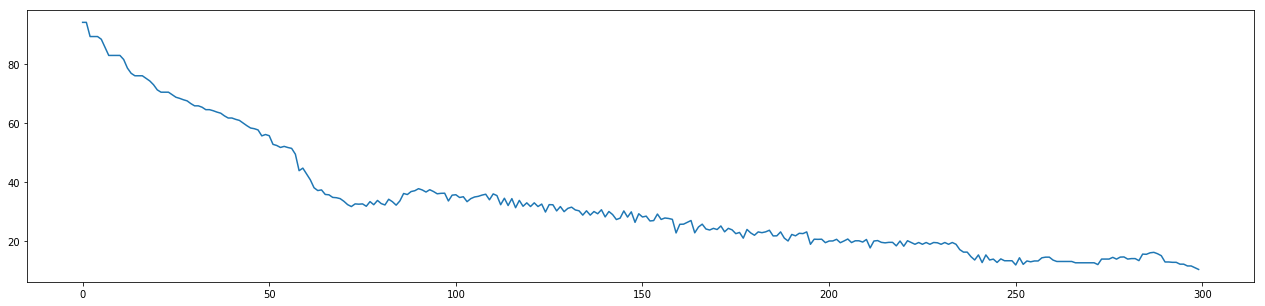

8 :: ----------------------------------
[(9, 15), (21, 21), (10, 13), (19, 28)]
target count  :  [179. 179. 179. 179.]
before darp
current count :  [136 244 245  91]
RMSE :  67.4054893907017

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 436.40 ms

after darp
current_count :  [179 178 179 180]
RMSE :  0.7071067811865476




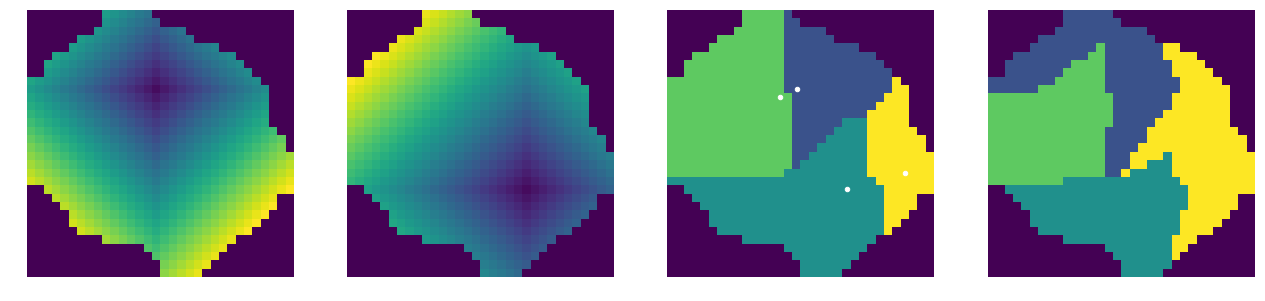

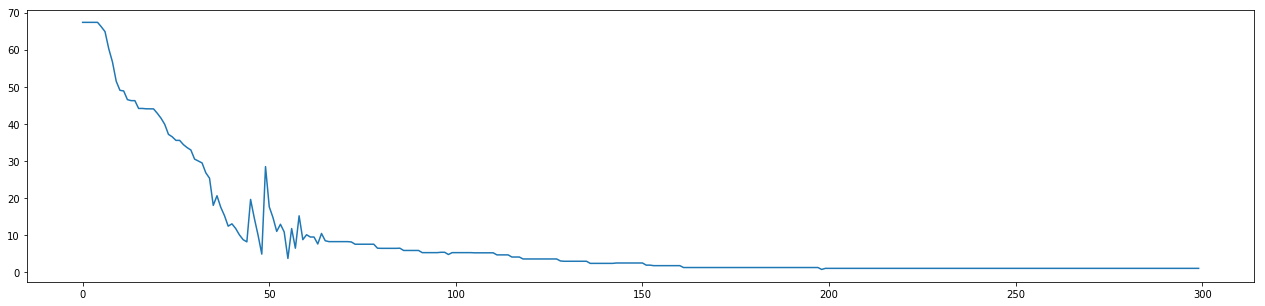

9 :: ----------------------------------
[(46, 31), (35, 2), (47, 30), (10, 36)]
target count  :  [368. 368. 368. 368.]
before darp
current count :  [318 456  61 637]
RMSE :  210.27006444094698

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 7949.97 ms

after darp
current_count :  [355 356 365 396]
RMSE :  16.62828914831589




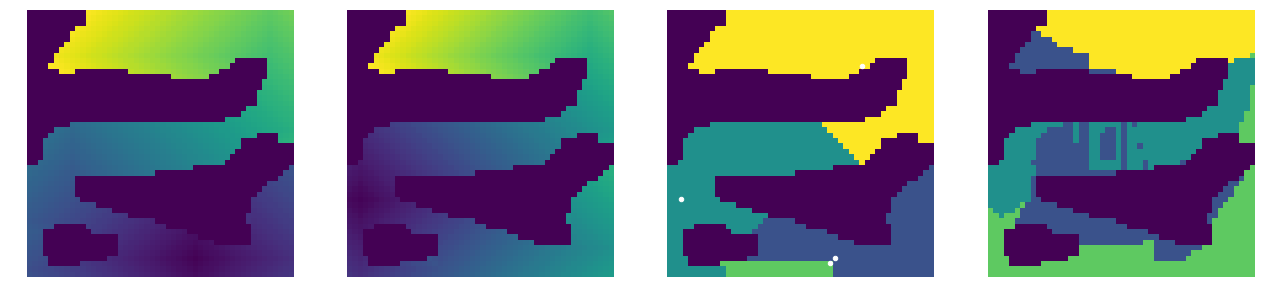

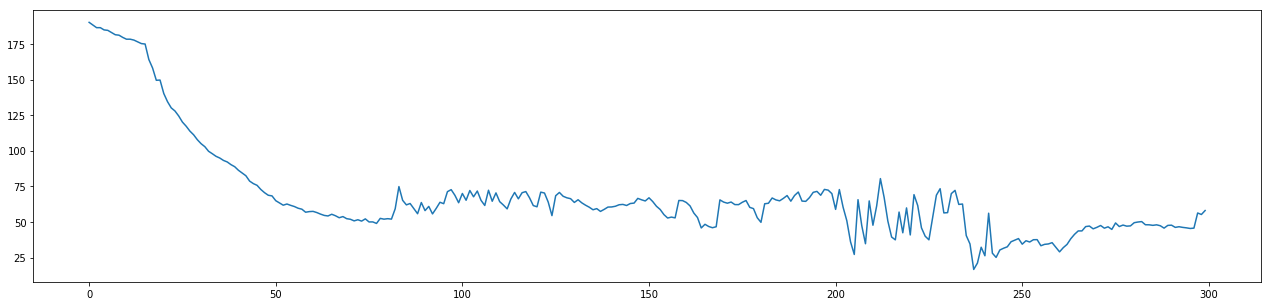

10 :: ----------------------------------
[(20, 5), (33, 1), (22, 7), (21, 1)]
target count  :  [330. 330. 330. 330.]
before darp
current count :  [  28   69 1182   39]
RMSE :  492.42004427114864

running DARP for 300 epochs...


  0%|          | 0/300 [00:00<?, ?it/s]

time taken for 300 epochs : 10113.88 ms

after darp
current_count :  [319 457 268 274]
RMSE :  76.20695506316993




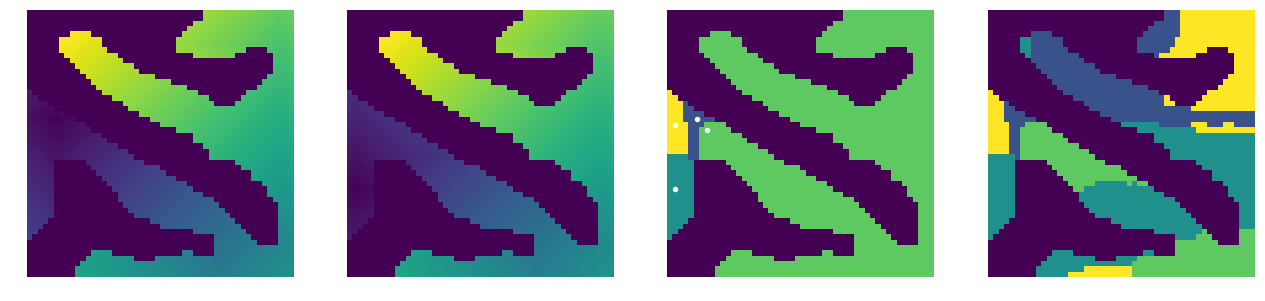

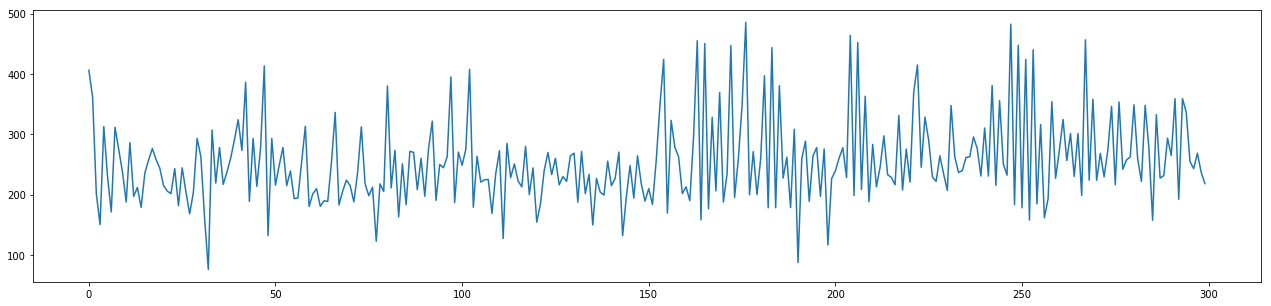

In [10]:
for i in range(11):
    A, losses = darp_run(i, 4, epochs=300, start_points=start_points, use_flood=False)